<div class="alert alert-block alert-success">
    <h1 align="center">Logistic Regression With Mini-Batch Gradient Descent</h1>

# Objective
* Represent your data as a Dataset object
* Create a Logistic Regression Model using PyTorch
* Set a Criterion to calculate Loss
* Create a Data Loader and set the Batch Size
* Create an Optimizer to update Model Parameters and set Learning Rate
* Train a Model
* X has 1 feature only

# Ref
* [Kaggle notebook](https://www.kaggle.com/code/dbais001/logistic-regression-use-mini-batch-gradientdescent/edit)

# Table of Contents
In this section, you will learn how to train a PyTorch Logistic Regression model using Mini-Batch Gradient Descent.

* Load Data
* Create the Model and Total Loss Function (Cost)
* Setting the Batch Size using a Data Loader
* Setting the Learning Rate
* Train the Model via Mini-Batch Gradient Descent vs SGD

# Libraries

In [2]:
!pip3 install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 16.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 37.2 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.8 MB/s eta 0:00:000m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 26.5 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 53.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 60.2 MB/s eta 0:00:000m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 60.3 MB/s eta 0:00:00m eta 0:00:010:01


In [3]:
# Allows us to use arrays to manipulate and store data
import numpy as np
# Used to graph data and loss curves
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# PyTorch Library
import torch
# Used to help create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader
# PyTorch Neural Network
import torch.nn as nn

The class **plot_error_surfaces** is just to help you visualize the data space and the parameter space during training and has nothing to do with Pytorch.

In [4]:
# Create class for plotting and the function for plotting
# just for demonstration purpose

class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x[self.y==0], self.y[self.y==0], 'ro', label="training points")
        plt.plot(self.x[self.y==1], self.y[self.y==1]-1, 'o', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

In [5]:
# Setting the seed will allow us to control randomness and give us reproducibility
torch.manual_seed(0)

In [32]:
class Data(Dataset):
    def __init__(self):
        self.x = torch.arange(-1,1,0.1).view(-1,1)
        self.y = torch.zeros(self.x.shape[0],1)
        # Set the X values above 0.2 to 1
        self.y[self.x[:, 0] > 0.2] = 1
        # Set the .len attribute because we need to override the __len__ method
        self.len = self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [33]:
# Create Data object
data_set = Data()

In [34]:
data_set.x

tensor([[-1.0000e+00],
        [-9.0000e-01],
        [-8.0000e-01],
        [-7.0000e-01],
        [-6.0000e-01],
        [-5.0000e-01],
        [-4.0000e-01],
        [-3.0000e-01],
        [-2.0000e-01],
        [-1.0000e-01],
        [-2.9802e-09],
        [ 1.0000e-01],
        [ 2.0000e-01],
        [ 3.0000e-01],
        [ 4.0000e-01],
        [ 5.0000e-01],
        [ 6.0000e-01],
        [ 7.0000e-01],
        [ 8.0000e-01],
        [ 9.0000e-01]])

In [35]:
data_set.y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [36]:
x,y = data_set[0]
print("x = {},  y = {}".format(x,y))

x = tensor([-1.]),  y = tensor([0.])


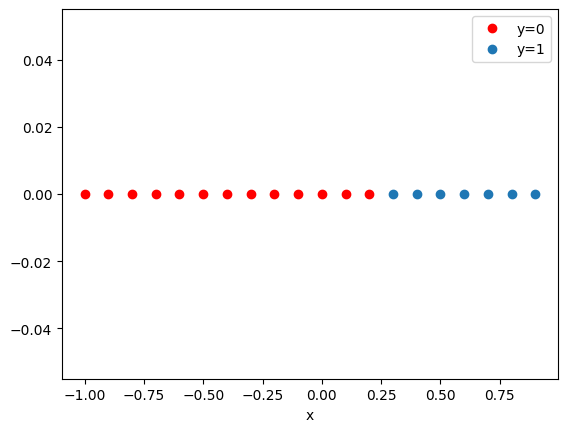

In [37]:
plt.plot(data_set.x[data_set.y==0], data_set.y[data_set.y==0], 'ro', label="y=0")
plt.plot(data_set.x[data_set.y==1], data_set.y[data_set.y==1]-1, 'o', label="y=1")
plt.xlabel('x')
plt.legend() 

# Create the Model and Total Loss Function (Cost)
For Logistic Regression typically we would not use PyTorch instead we would use Scikit-Learn as it is easier to use and set up. We are using PyTorch because it is good practice for deep learning. Scikit-Learn is typically used for Machine Learning while PyTorch is used for Deep Learning.

We will create a custom class that defines the architecture of Logistic Regression using PyTorch. Logistic Regression has a single layer where the input is the number of features an X value of the dataset has (dimension of X) and there is a single output. The output of the layer is put into a sigmoid function which is a function between 0 and 1. The larger the output of the layer the closer it is to 1 and the smaller the output is the closer it is to 0. The sigmoid function will allow us to turn this output into a classification problem. If the output value is closer to 1 it is one class if it is closer to 0 it is in another.

Sigmoid Function

![](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

In [38]:
class logistic_regression(nn.Module):
    def __init__(self, n_inputs):
        super(logistic_regression,self).__init__()
        self.linear = nn.Linear(n_inputs,1)
    def forward(self,x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

In [39]:
x,y = data_set[0]
len(x)

1

In [40]:
x

tensor([-1.])

In [41]:
y

tensor([0.])

In [42]:
# Create the logistic_regression result

model = logistic_regression(1)

In [43]:
x = torch.tensor([-1.0])
sigma = model(x)
sigma

tensor([0.6927], grad_fn=<SigmoidBackward0>)

In [44]:
x,y = data_set[2]

sigma = model(x)
sigma

tensor([0.6918], grad_fn=<SigmoidBackward0>)

Create a plot_error_surfaces object to visualize the data space and the learnable parameters space during training:

We can see on the Loss Surface graph, the loss value varying across w and b values with yellow being high loss and dark blue being low loss which is what we want

On the Loss Surface Contour graph we can see a top-down view of the Loss Surface graph

<Figure size 640x480 with 0 Axes>

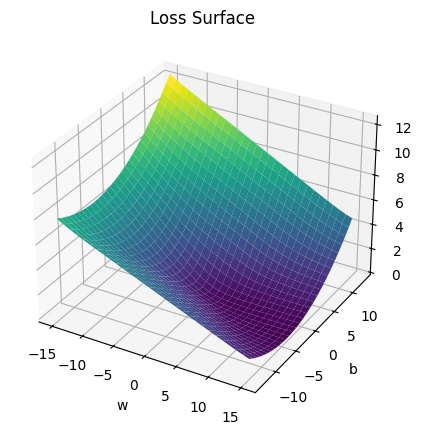

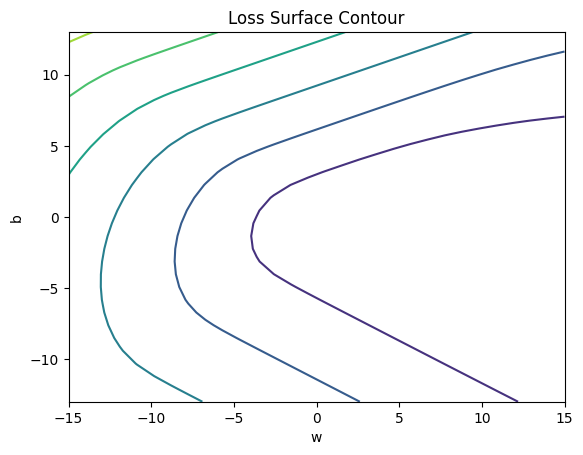

In [45]:
# Create the plot_error_surfaces object

# 15 is the range of w
# 13 is the range of b
# data_set[:][0] are all the X values
# data_set[:][1] are all the Y values

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1])

We define a criterion using **Binary Cross Entropy** Loss. This will measure the difference/loss between the prediction and actual value.

In [46]:
criteria = nn.BCELoss()

In [47]:
data_set

# Setting the Batch Size using a Data Loader
You have to use data loader in PyTorch that will output a batch of data, the input is the dataset and batch_size

In [48]:
trainloader = DataLoader(dataset = data_set, batch_size = 10)

In [49]:
dataset_iter = iter(trainloader)

In [50]:
dataset_iter

In [51]:
trainloader

In [52]:
X,y=next(dataset_iter)

In [53]:
X

tensor([[-1.0000],
        [-0.9000],
        [-0.8000],
        [-0.7000],
        [-0.6000],
        [-0.5000],
        [-0.4000],
        [-0.3000],
        [-0.2000],
        [-0.1000]])

# Setting the Learning Rate
We can set the learning rate by setting it as a parameter in the optimizer along with the parameters of the logistic regression 
model we are training. The job of the optimizer, torch.optim.SGD, is to use the loss generated by the criterion to update the model 
parameters according to the learning rate. SGD stands for Stochastic Gradient Descent which typically means that the batch size is set to 1, but the data loader we set up above has 
turned this into Mini-Batch Gradient Descent.

In [1]:
learning_rate = 0.1

In [55]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0198]], requires_grad=True),
 Parameter containing:
 tensor([0.7929], requires_grad=True)]

In [56]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train the Model via Mini-Batch Gradient Descent
We are going to train the model using various Batch Sizes and Learning Rates.

**Mini-Batch Gradient Descent**

In this case, we will set the batch size of the data loader to 5 and the number of epochs to 250.

First, we must recreate the get_surface object again so that for each example we get a Loss Surface for that model only.

<Figure size 640x480 with 0 Axes>

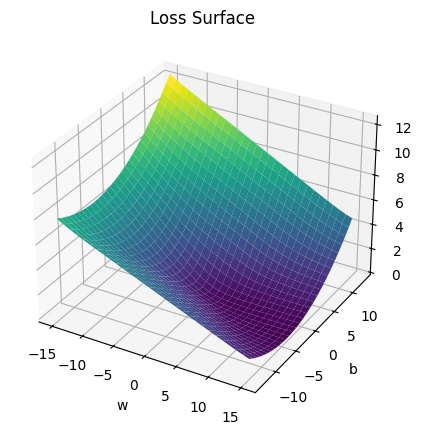

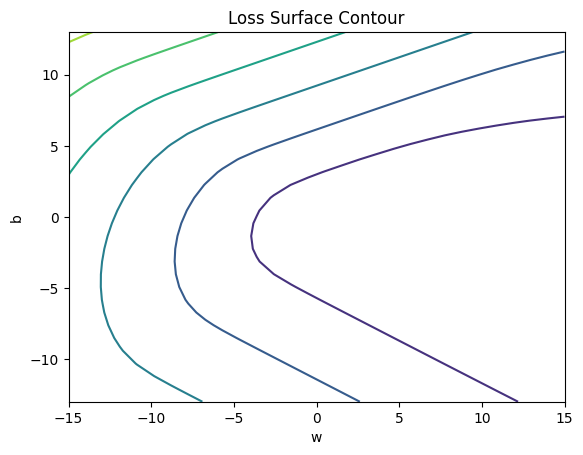

In [57]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

**Train the Model**

In [60]:
model = logistic_regression(1)
criteria = nn.BCELoss()
traindataloader = DataLoader(dataset = data_set, batch_size = 5)
optimizer = torch.optim.SGD(model.parameters(), lr =0.1)
epochs = 500
loss_values = []

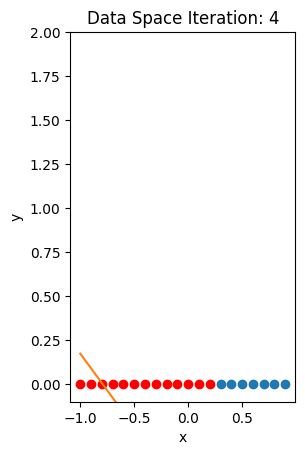

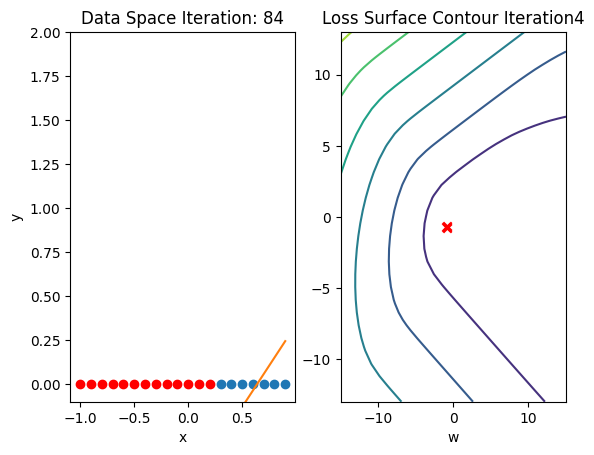

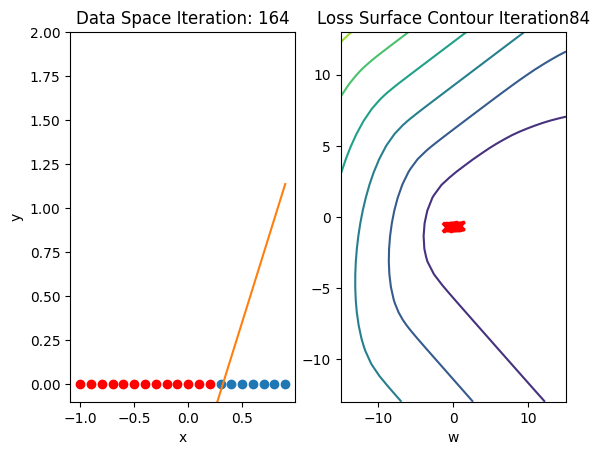

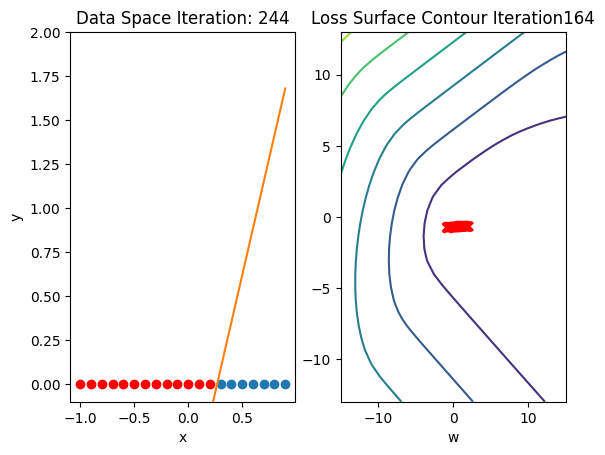

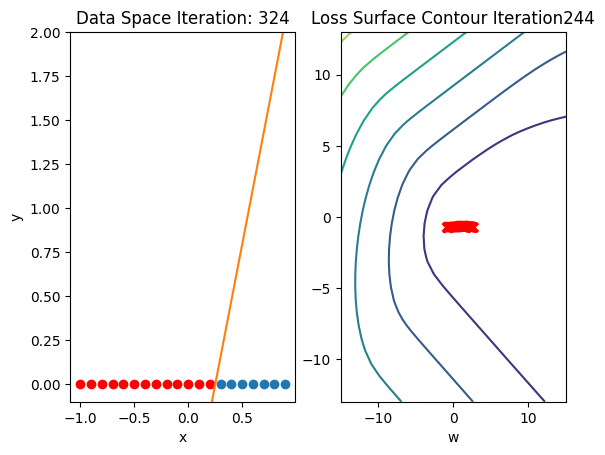

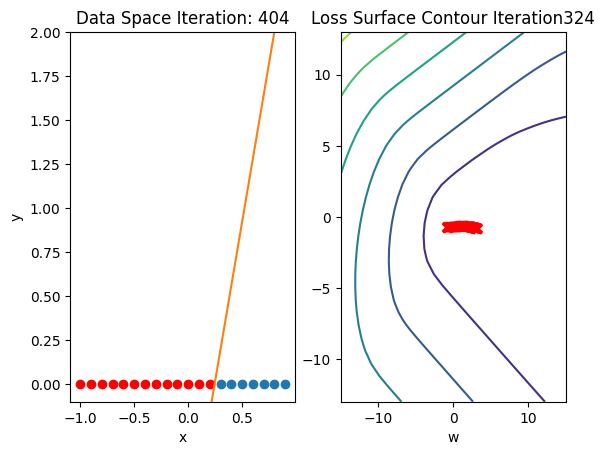

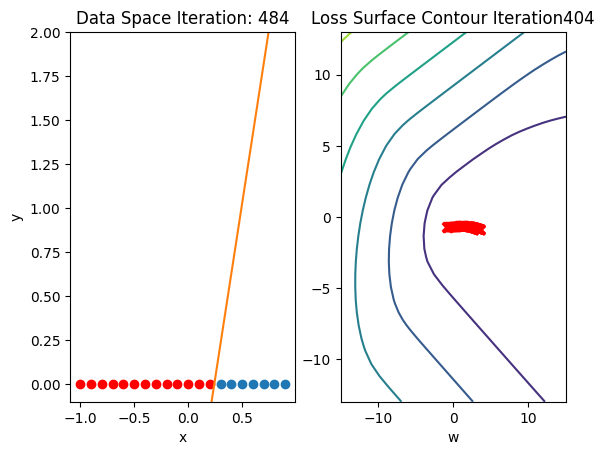

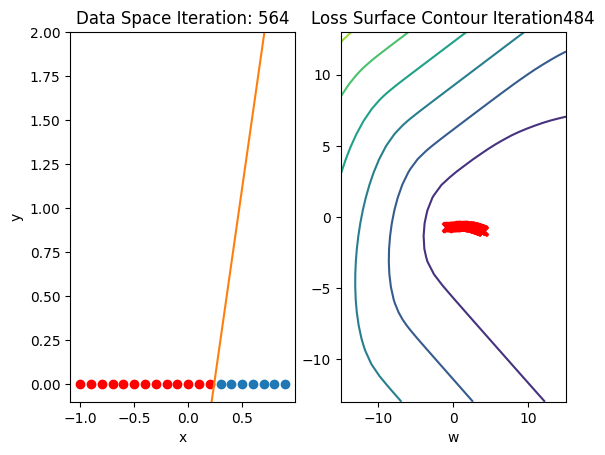

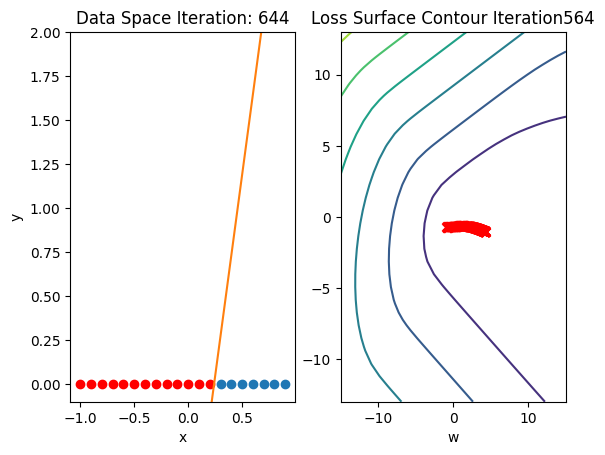

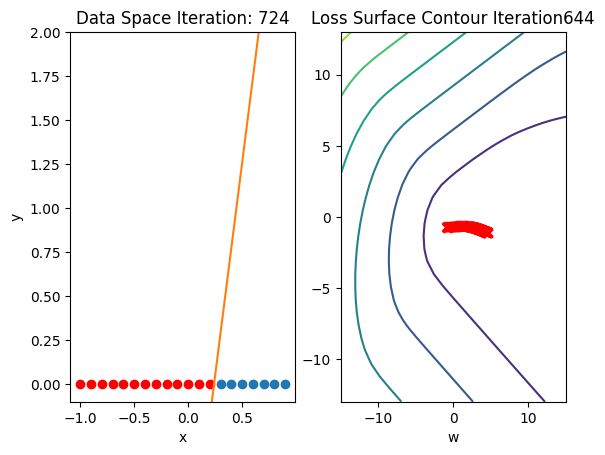

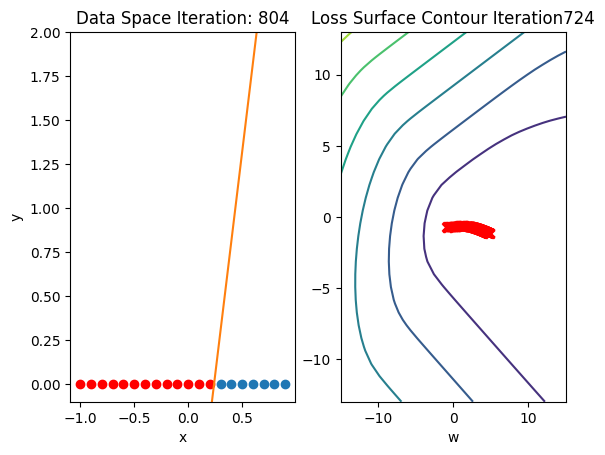

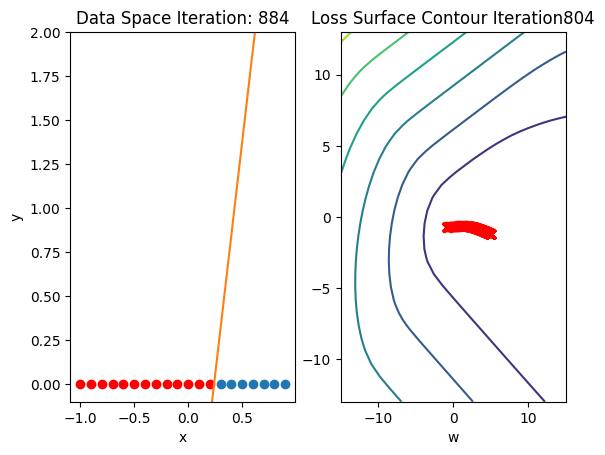

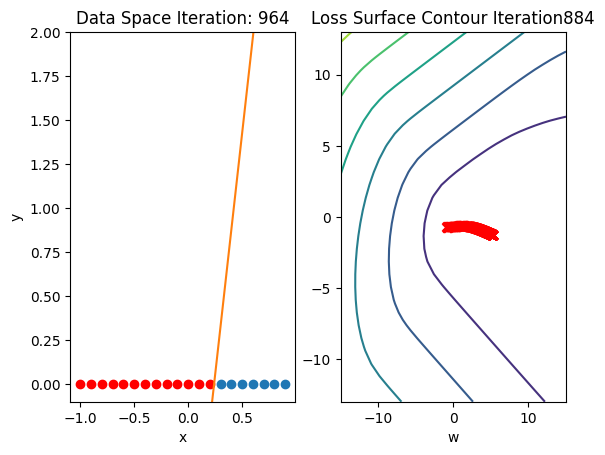

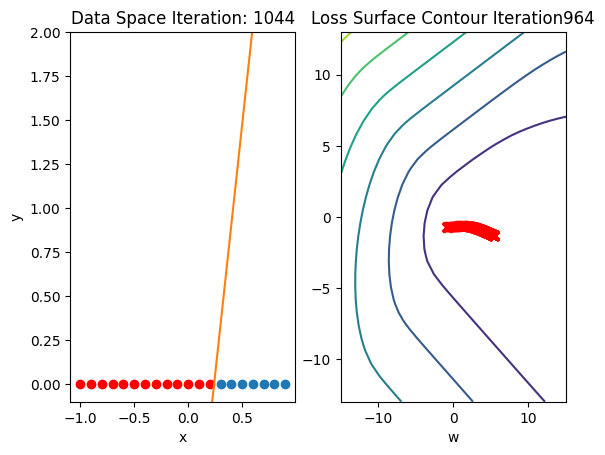

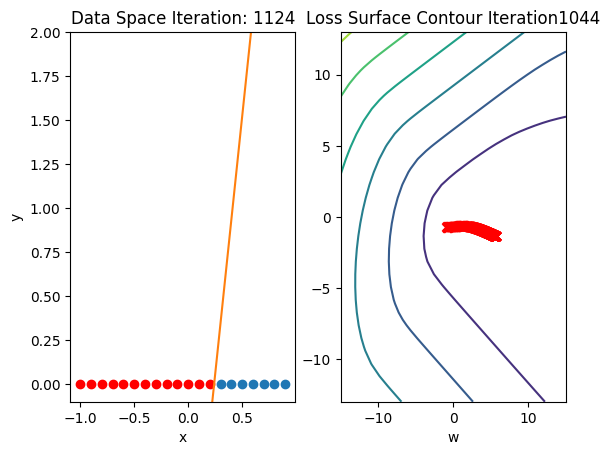

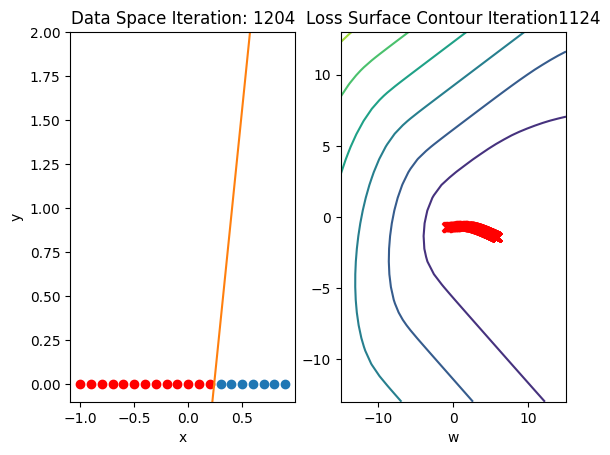

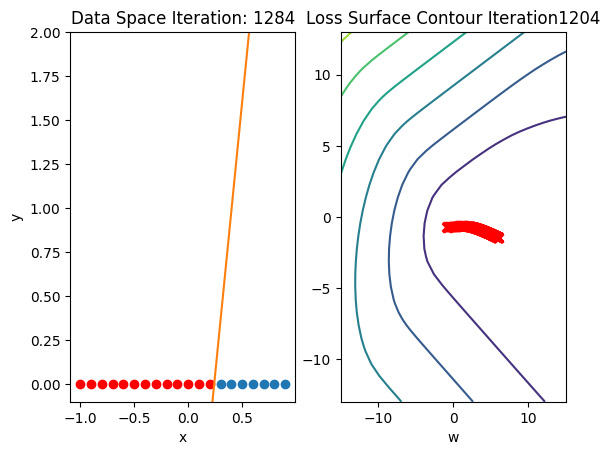

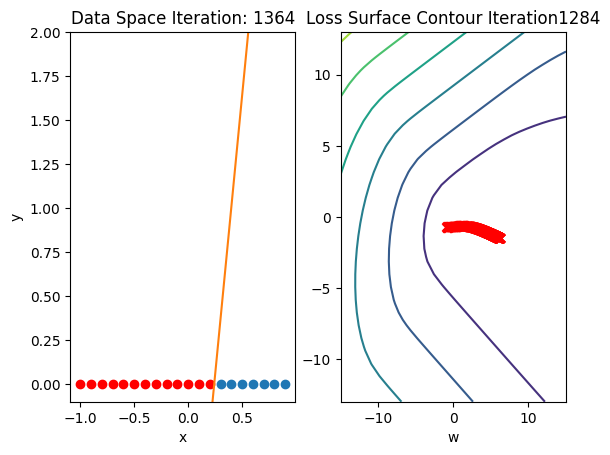

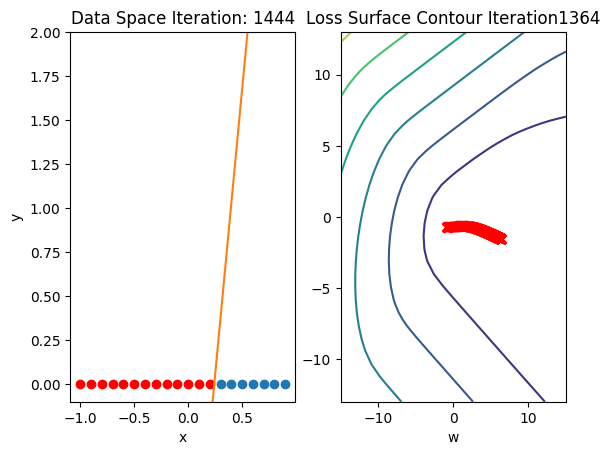

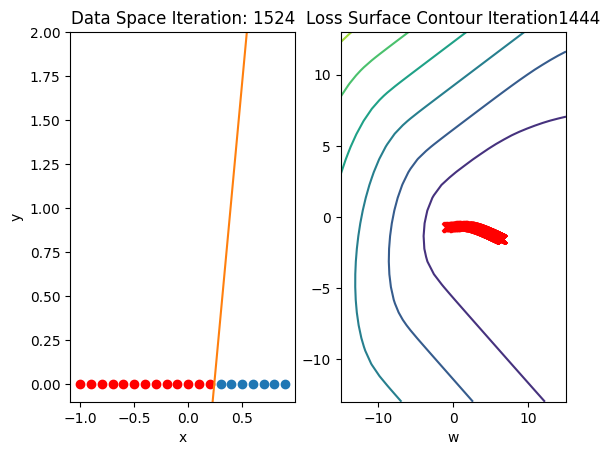

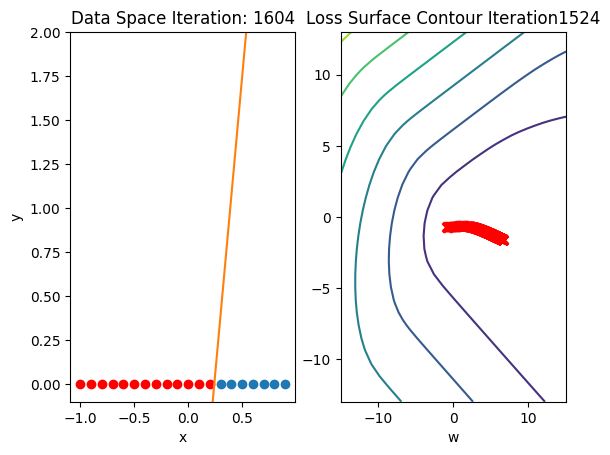

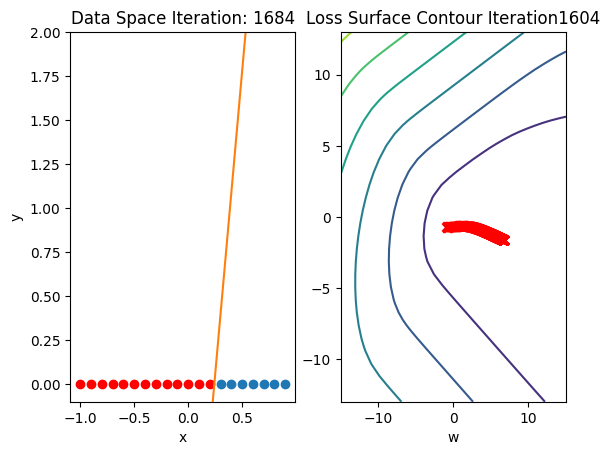

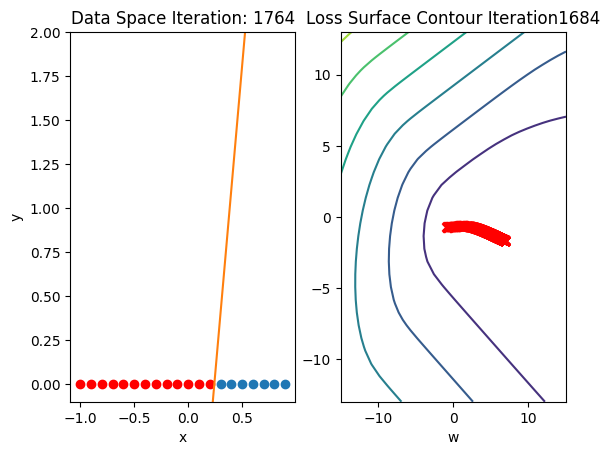

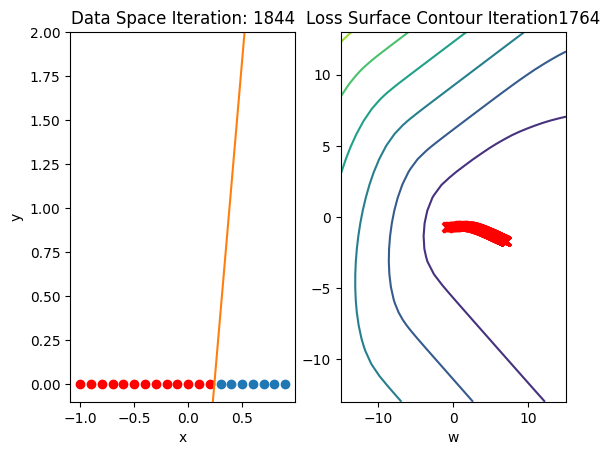

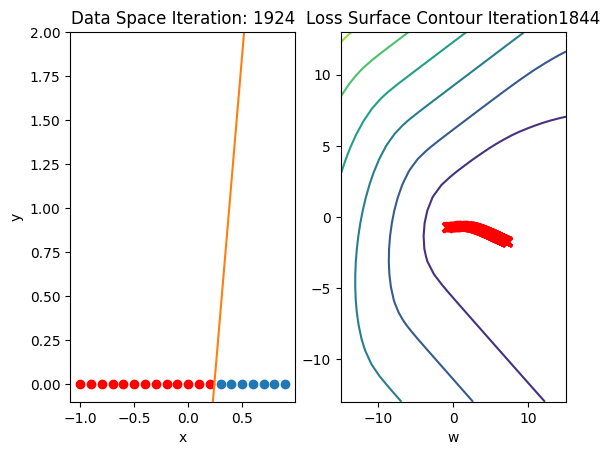

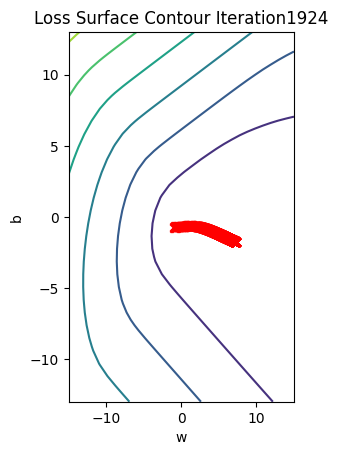

In [62]:
for epoch in range(epochs):
    for x,y in traindataloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criteria(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()


In [63]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([7.3676]) b =  tensor(-1.7913)


In [64]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


/tmp/ipykernel_10707/2755647947.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_values = torch.tensor(loss_values)


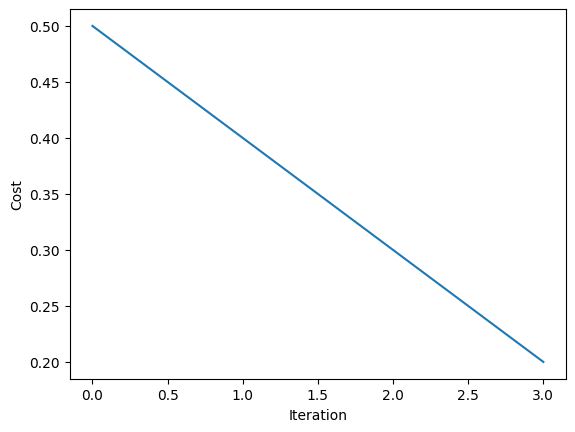

In [67]:
# Assuming loss_values is a PyTorch tensor
loss_values = torch.tensor(loss_values)

# Use tensor.detach().numpy() to convert the PyTorch tensor to a NumPy array
plt.plot(loss_values.detach().numpy())
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [66]:
loss_values

tensor([0.5000, 0.4000, 0.3000, 0.2000])